# WannierBerri advanced tutorial - Fermi surface and Fermi sea calculation of the Berry curvature dipole

author: Jae-Mo Lihm (jaemo.lihm@gmail.com)

The Berry curvature dipole (BCD) is the dipole of the Berry curvature in the reciprocal space. BCD has attracted considerable attention, partially because it contributes to the nonlinear Hall effect.

In WannierBerri, there are two ways to compute this quantity: the Fermi surface integral and the Fermi sea integral:
$$D^{\rm surf.}_{ab} = -\int_{\rm BZ} d\mathbf{k} \sum_n \left[ \frac{\partial}{\partial k^a} f_0 (\varepsilon_{n\mathbf{k}}) \right] \Omega^b_{n\mathbf{k}}$$
$$D^{\rm sea.}_{ab} = \int_{\rm BZ} d\mathbf{k} \sum_n f_0 (\varepsilon_{n\mathbf{k}}) \left(\frac{\partial}{\partial k^a} \Omega^b_{n\mathbf{k}} \right)$$

Formally, one can show that the two methods give identical results using partial integration:
$$D^{\rm sea.}_{ab} - D^{\rm surf.}_{ab}
= \int_{\rm BZ} d\mathbf{k} \frac{\partial}{\partial k^a} \left[ \sum_n f_0 (\varepsilon_{n\mathbf{k}}) \Omega^b_{n\mathbf{k}} \right]
= 0.
$$
The integral is zero because the Brillouin zone has no boundary.

However, in practice, there are numerical differences between the two methods. In this tutorial, we compare the Fermi sea and Fermi surface integral methods for the BCD using the chiral tight-binding model and the ab-initio tight-binding model of ferroelectric GeTe.

In [1]:
# Preliminary (Do only once)
%load_ext autoreload
%autoreload 2

# Set environment variables - not mandatory but recommended
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1' 
os.environ['MKL_NUM_THREADS'] = '1'


import numpy as np
import scipy
import matplotlib.pyplot as plt
import wannierberri as wberri
from wannierberri import calculators as calc

#  This block is needed if you run this cell for a second time
#  because one cannot initiate two parallel environments at a time
try:
    parallel.shutdown()   
except NameError:
    pass

parallel = wberri.Parallel(num_cpus=16, progress_step_percent=10)

initializing ray with  {'num_cpus': 16}


2025-05-13 16:35:59,595	INFO worker.py:1879 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8267 


## Model 1: Chiral tight-binding model

### Model, band structure
The model is taken from T. Yoda et al, "Orbital Edelstein Effect as a Condensed-Matter Analog of Solenoids", Nano Lett. 18, 2, 916–920 (2018)
https://arxiv.org/abs/1706.07702

The system is a honeycomb lattice with two orbitals per unit cell with an AA stacking (i.e. an AA stacked 2d hexagonal boron nitride). The original model contains in-plance nearest-neighbor hopping (`hop1`), vertical hopping (`hopz_vert`), and chiral inter-layer hopping (`hopz_left` and `hopz_right`).
Here, we additionally add onsite energy difference (`delta`) and in-plane next-nearest-neighbor hopping (`hop2` and `phi`). Nonzero `phi` breaks the time-reversal symmetry.

When we set `phi=0`, the model has time-reversal symmetry and C3z symmetry. In total, there are 6 symmetry operations.

In [2]:
import wannierberri.models

# Initiate a tight-binding model (wannierberri.models.Chiral uses PythTB)
model_Chiral_left = wannierberri.models.Chiral(delta=2., hop1=1., hop2=0.3, phi=0, hopz_left=0.2, hopz_right=0.0, hopz_vert=0)

# Initialize WannierBerri system object
system = wberri.System_PythTB(model_Chiral_left)

print("=" * 40)

# Set symmetry from the generators.
system.set_pointgroup(symmetry_gen=["TimeReversal", "C3z"])
print("Number of symmetry operations: ", system.pointgroup.size)

number of wannier functions: 2
R=0 found at position(s) [[10]]
shape of Ham_R = (21, 2, 2)
Real-space lattice:
 [[1.        0.        0.       ]
 [0.5       0.8660254 0.       ]
 [0.        0.        1.       ]]
Number of wannier functions: 2
Number of R points: 21
Recommended size of FFT grid [3 3 3]
Reading the system from PythTB finished successfully
Number of symmetry operations:  6


Now, we plot the band structure along a k-point path that passes the high-symmetry k points. We use the `plot_path_fat` method to plot the band structure.

The energy can be accessed via `path_result.get_data("Energy", iband)`.
The valence band maximum is at the Gamma point, while the conduction band minimum on the K-H line.

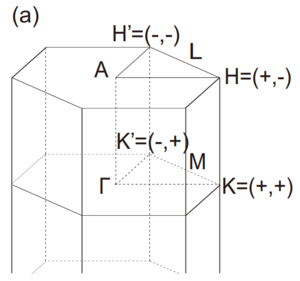

Figure taken from T. Yoda et al, Nano Lett. 18, 2, 916–920 (2018).

In [3]:
path = wberri.Path(
    system,
    k_nodes=[
        [2/3, 1/3, 0.],  #  K
        [0.,  0.,  0.],  #  Gamma
        [1/2, 0.,  0.],  #  M
        [2/3, 1/3, 0.],  #  K
        [2/3, 1/3, 0.5],  #  H
        [0.,  0.,  0.5],  #  A
        [1/2, 0.,  0.5],  #  L
        [2/3, 1/3, 0.5],  #  H
    ],
    labels=["K","$\Gamma$","M","K", "H", "A", "L", "H"],
    length=50
)

calculators = {
    "tabulate": calc.TabulatorAll(
        {"Energy": calc.tabulate.Energy()},
        ibands=np.arange(system.num_wann),
        mode="path",
    )
}

path_result = wberri.run(
    system,
    grid=path,
    calculators=calculators,
    parallel=parallel,
    print_Kpoints = False,
)

path_result = path_result.results["tabulate"]

Starting run()
Using the follwing calculators : 
############################################################

 'tabulate'  :  <wannierberri.calculators.tabulate.TabulatorAll object at 0x776ec8114f20>  : 
    TabulatorAll - a pack of all k-resolved calculators (Tabulators)
    
 Includes the following tabulators : 
--------------------------------------------------
 "Energy" : <wannierberri.calculators.tabulate.Energy object at 0x776f080f3e00> : calculator not described

--------------------------------------------------

############################################################
Calculation along a path - checking calculators for compatibility
tabulate <wannierberri.calculators.tabulate.TabulatorAll object at 0x776ec8114f20>
All calculators are compatible
Symmetrization switched off for Path
Grid is regular
The set of k points is a Path() with 184 points and labels {0: 'K', 33: '$\\Gamma$', 62: 'M', 79: 'K', 104: 'H', 137: 'A', 166: 'L', 183: 'H'}
generating K_list
Done 
Done, sum o

<>:13: SyntaxWarning: invalid escape sequence '\G'
<>:13: SyntaxWarning: invalid escape sequence '\G'
/tmp/ipykernel_98527/3984238173.py:13: SyntaxWarning: invalid escape sequence '\G'
  labels=["K","$\Gamma$","M","K", "H", "A", "L", "H"],
/home/stepan/github/wannier-berri/wannierberri/grid/path.py:163: UserWarning: symmetry is not used for a tabulation along path
  warnings.warn("symmetry is not used for a tabulation along path")


time for processing    184 K-points on   1 processes:     0.7157 ; per K-point          0.0039 ; proc-sec per K-point          0.0039
time1 =  0.0020780563354492188
Totally processed 184 K-points 
run() finished


Valence band maximum   : -0.606
Conduction band minimum: -0.099
VBM k point:  [0. 0. 0.]
CBM k point:  [0.66666667 0.33333333 0.16      ]


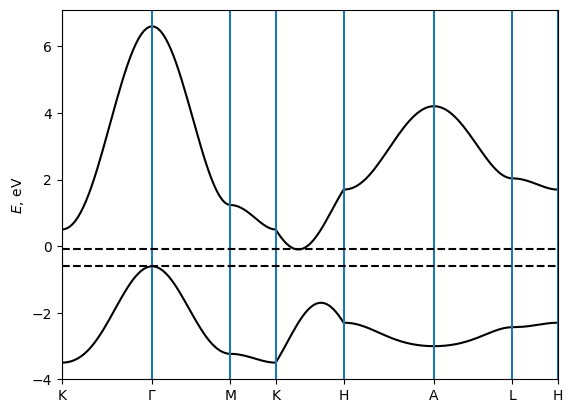

In [4]:
e_vbm = np.amax(path_result.get_data("Energy", 0))
e_cbm = np.amin(path_result.get_data("Energy", 1))
print(f"Valence band maximum   : {e_vbm:6.3f}")
print(f"Conduction band minimum: {e_cbm:6.3f}")

print("VBM k point: ", path_result.kpoints[np.argmax(path_result.get_data("Energy", 0))])
print("CBM k point: ", path_result.kpoints[np.argmin(path_result.get_data("Energy", 1))])

fig = path_result.plot_path_fat(path, close_fig=False, show_fig=False)

ax = fig.get_axes()[0]
ax.axhline(e_vbm, c="k", ls="--")
ax.axhline(e_cbm, c="k", ls="--")
plt.show(fig)

### Berry curvature dipole

In [5]:
from wannierberri.smoother import FermiDiracSmoother

efermi = np.linspace(-2.0, 1.0, 101, True)
# efermi = np.linspace(e_vbm - 0.5, e_cbm + 0.5, 301, True)

kwargs = dict(
    Efermi=efermi,
    kwargs_formula={"external_terms": False},
    smoother=FermiDiracSmoother(efermi, T_Kelvin=1200, maxdE=8)
)

calculators = {
    'berry_dipole_fermi_sea': calc.static.BerryDipole_FermiSea(**kwargs),
    'berry_dipole_fermi_surface': calc.static.BerryDipole_FermiSurf(**kwargs),
    'dos': calc.static.DOS(Efermi=efermi,),
}

Compare calculations using the full k-point grid and the irreducible grid. This can be done using the `use_irred_kpt` argument of `wberri.run`.

You can find the following two lines in the output:<br>
`K_list contains 1000 Irreducible points(100.0%) out of initial 10x10x10=1000 grid`<br>
`K_list contains 172 Irreducible points(17.2%) out of initial 10x10x10=1000 grid`<br>

These lines show that using symmetry can speed up calculation by 1000 / 172 ~ 6 times. This speedup corresponds to the 6 symmetry operations. Check that the BCD calculated from the two grids are identical.

In [6]:
grid = wberri.Grid(system, NK=20, NKFFT=2)
print("=" * 40)
print("Calculation using the full k-point grid")
result_full_grid = wberri.run(
    system,
    grid=grid,
    calculators=calculators,
    parallel=parallel,
    print_Kpoints = False,
    use_irred_kpt = False,
)

print("=" * 40)
print("Calculation using the irreducible k-point grid")
result_irr_grid = wberri.run(
    system,
    grid=grid,
    calculators=calculators,
    parallel=parallel,
    print_Kpoints = False,
    use_irred_kpt = True,
)

Calculation using the full k-point grid
Starting run()
Using the follwing calculators : 
############################################################

 'berry_dipole_fermi_sea'  :  <wannierberri.calculators.static.BerryDipole_FermiSea object at 0x776f0812c080>  : Berry curvature dipole (dimensionless)

        | With Fermi sea integral. Eq(29) in `Ref <https://www.nature.com/articles/s41524-021-00498-5>`__
        | Output: :math:`D_{\beta\delta} = \int [dk] \partial_\beta \Omega_\delta f`
 'berry_dipole_fermi_surface'  :  <wannierberri.calculators.static.BerryDipole_FermiSurf object at 0x776ec04c1ee0>  : Berry curvature dipole (dimensionless)

        | With Fermi surface integral. Eq(8) in `Ref <https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.115.216806>`__
        | Output: :math:`D_{\beta\delta} = -\int [dk] v_\beta \Omega_\delta f'`
 'dos'  :  <wannierberri.calculators.static.DOS object at 0x776ec04c20f0>  : Density of states
#############################################

time for processing   1000 K-points on   1 processes:     4.0077 ; per K-point          0.0040 ; proc-sec per K-point          0.0040
time1 =  0.08731341361999512
Totally processed 1000 K-points 
run() finished
Calculation using the irreducible k-point grid
Starting run()
Using the follwing calculators : 
############################################################

 'berry_dipole_fermi_sea'  :  <wannierberri.calculators.static.BerryDipole_FermiSea object at 0x776f0812c080>  : Berry curvature dipole (dimensionless)

        | With Fermi sea integral. Eq(29) in `Ref <https://www.nature.com/articles/s41524-021-00498-5>`__
        | Output: :math:`D_{\beta\delta} = \int [dk] \partial_\beta \Omega_\delta f`
 'berry_dipole_fermi_surface'  :  <wannierberri.calculators.static.BerryDipole_FermiSurf object at 0x776ec04c1ee0>  : Berry curvature dipole (dimensionless)

        | With Fermi surface integral. Eq(8) in `Ref <https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.115.216806>`__
  

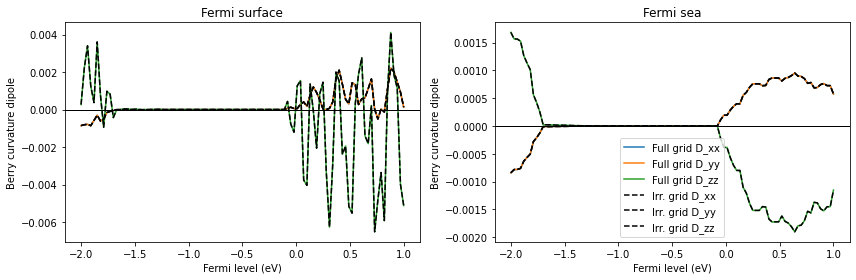

In [164]:
dir_string = ["D_xx", "D_yy", "D_zz"]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for label, res in zip(["Full grid", "Irr. grid"], [result_full_grid, result_irr_grid]):
    data_fsurf = res.results['berry_dipole_fermi_surface'].data
    data_fsea = res.results['berry_dipole_fermi_sea'].data
    for i in range(3):
        if label == "Full grid":
            fmt = f"C{i}-"
        else:
            fmt = "k--"
        axes[0].plot(efermi, data_fsurf[:, i, i], fmt, label=label + " " + dir_string[i])
        axes[1].plot(efermi, data_fsea[:, i, i], fmt, label=label + " " + dir_string[i])

axes[0].set_title("Fermi surface")
axes[1].set_title("Fermi sea")

for ax in axes:
    ax.axhline(0, c="k", lw=1)
    ax.set_xlabel("Fermi level (eV)")
    ax.set_ylabel("Berry curvature dipole")

axes[1].legend()
plt.tight_layout()
plt.show()

From now on, we use the irreducible k-point grid, which is the default in `wberri.run`.

In [7]:
grid = wberri.Grid(system, NK=20, NKFFT=2)
result = wberri.run(
    system,
    grid=grid,
    calculators=calculators,
    parallel=parallel,
    print_Kpoints = False,
)

Starting run()
Using the follwing calculators : 
############################################################

 'berry_dipole_fermi_sea'  :  <wannierberri.calculators.static.BerryDipole_FermiSea object at 0x776f0812c080>  : Berry curvature dipole (dimensionless)

        | With Fermi sea integral. Eq(29) in `Ref <https://www.nature.com/articles/s41524-021-00498-5>`__
        | Output: :math:`D_{\beta\delta} = \int [dk] \partial_\beta \Omega_\delta f`
 'berry_dipole_fermi_surface'  :  <wannierberri.calculators.static.BerryDipole_FermiSurf object at 0x776ec04c1ee0>  : Berry curvature dipole (dimensionless)

        | With Fermi surface integral. Eq(8) in `Ref <https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.115.216806>`__
        | Output: :math:`D_{\beta\delta} = -\int [dk] v_\beta \Omega_\delta f'`
 'dos'  :  <wannierberri.calculators.static.DOS object at 0x776ec04c20f0>  : Density of states
############################################################
Calculation on  grid - c

In [8]:
data_fsurf = result.results['berry_dipole_fermi_surface'].data
data_fsea = result.results['berry_dipole_fermi_sea'].data

print("Shape of data: ", data_fsurf.shape)

print("Maximum value for each components (Fermi surface): ")
print(np.linalg.norm(data_fsurf, axis=0))

print("Maximum value for each components (Fermi sea): ")
print(np.linalg.norm(data_fsea, axis=0))

Shape of data:  (101, 3, 3)
Maximum value for each components (Fermi surface): 
[[6.21590176e-03 8.59577012e-19 5.06603030e-18]
 [1.16684168e-18 6.21590176e-03 1.23671954e-18]
 [8.40279503e-19 2.24111542e-19 2.01147852e-02]]
Maximum value for each components (Fermi sea): 
[[4.68803509e-03 6.93422151e-19 1.39090780e-17]
 [2.63355804e-18 4.68803509e-03 1.58054575e-18]
 [3.17500857e-19 7.41680867e-20 9.37607018e-03]]


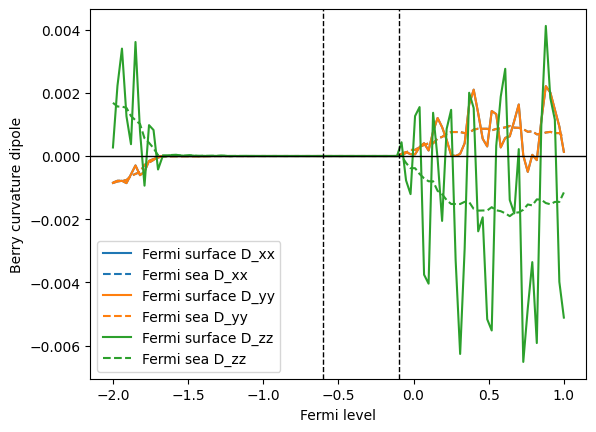

In [9]:
dir_string = ["D_xx", "D_yy", "D_zz"]
for i in range(3):
    plt.plot(efermi, data_fsurf[:, i, i], c=f"C{i}", label="Fermi surface " + dir_string[i])
    plt.plot(efermi, data_fsea[:, i, i], c=f"C{i}", label="Fermi sea " + dir_string[i], ls="--")
    
# plt.plot(efermi, result.results['dos'].data, "k-")

plt.axhline(0, c="k", lw=1)
plt.xlabel("Fermi level")
plt.ylabel("Berry curvature dipole")
plt.axvline(e_vbm, c="k", lw=1, ls="--")
plt.axvline(e_cbm, c="k", lw=1, ls="--")
plt.legend()
plt.show()

The trace of the BCD tensor should be zero due to a topological reason (see footnote 2 of [S.Tsirkin et al, PRB 97, 035158 (2018)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.97.035158) for details).

The Fermi sea formula for the BCD tensor is explicitly traceless at every k point: this fact can be proven from the definition of the Fermi sea formula using
$$
\sum_{a} \frac{\partial}{\partial k^a} \Omega^a_{n\mathbf{k}}
= \sum_{a} \epsilon_{abc} \frac{\partial}{\partial k^a} \frac{\partial}{\partial k^b} A^c_{n\mathbf{k}}
= 0.
$$


In contrast, tracelessness is not explicit in the Fermi surface formula. The trace of the BCD tensor becomes zero only after summing over the full Brillouin zone due to the cancellation of contributions from all the k points.

Therefore, in numerical calculations using a finite number of k points, only the Fermi sea formula, not the Fermi surface formula, gives a zero trace. The trace will converge to 0 in the Fermi surface case as one makes the k-point grid denser.

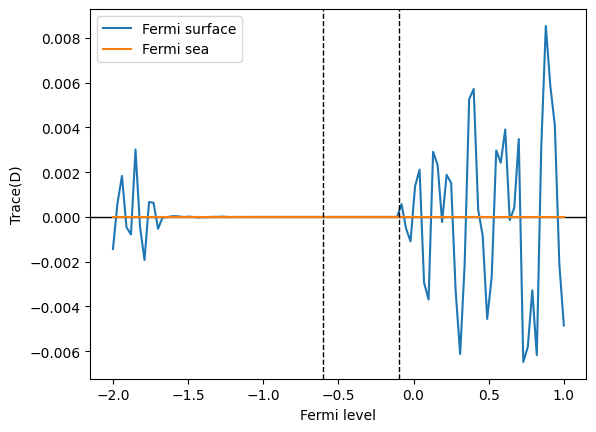

In [10]:
data_fsurf_trace = np.trace(data_fsurf, axis1=1, axis2=2)
data_fsea_trace = np.trace(data_fsea, axis1=1, axis2=2)

plt.plot(efermi, data_fsurf_trace, label="Fermi surface")
plt.plot(efermi, data_fsea_trace, label="Fermi sea")

plt.axhline(0, c="k", lw=1, zorder=1)
plt.xlabel("Fermi level")
plt.ylabel("Trace(D)")
plt.axvline(e_vbm, c="k", lw=1, ls="--")
plt.axvline(e_cbm, c="k", lw=1, ls="--")
plt.legend()
plt.show()

Try to calculate the Berry curvature dipole using the two methods for various grid sizes and see how they converge. Also, check that the trace of Berry curvature dipole indeed converges to 0 for both methods.

(NK=120 will be enough to see convergence.)

In [11]:
data_fsurf_all = {}
data_fsea_all = {}

In [12]:
for nk in [20, 40, 60, 80]:
    grid = wberri.Grid(system, NK=nk)
    result = wberri.run(
        system,
        grid=grid,
        calculators=calculators,
        parallel=parallel,
        print_Kpoints = False,
    )
    data_fsurf_all[nk] = result.results['berry_dipole_fermi_surface'].data
    data_fsea_all[nk] = result.results['berry_dipole_fermi_sea'].data

Minimal symmetric FFT grid :  [3 3 3]
Starting run()
Using the follwing calculators : 
############################################################

 'berry_dipole_fermi_sea'  :  <wannierberri.calculators.static.BerryDipole_FermiSea object at 0x776f0812c080>  : Berry curvature dipole (dimensionless)

        | With Fermi sea integral. Eq(29) in `Ref <https://www.nature.com/articles/s41524-021-00498-5>`__
        | Output: :math:`D_{\beta\delta} = \int [dk] \partial_\beta \Omega_\delta f`
 'berry_dipole_fermi_surface'  :  <wannierberri.calculators.static.BerryDipole_FermiSurf object at 0x776ec04c1ee0>  : Berry curvature dipole (dimensionless)

        | With Fermi surface integral. Eq(8) in `Ref <https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.115.216806>`__
        | Output: :math:`D_{\beta\delta} = -\int [dk] v_\beta \Omega_\delta f'`
 'dos'  :  <wannierberri.calculators.static.DOS object at 0x776ec04c20f0>  : Density of states
###############################################

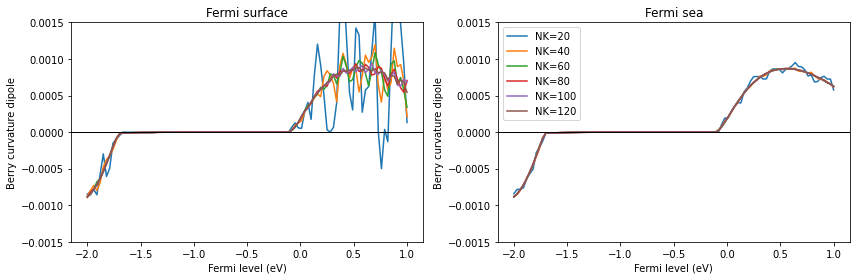

In [208]:
ic = 0
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
nklist = sorted(list(data_fsurf_all.keys()))

for nk in nklist:
    c = f"C{ic}"
    axes[0].plot(efermi, data_fsurf_all[nk][:, 0, 0], c=c, label=f"NK={nk}")
    axes[1].plot(efermi, data_fsea_all[nk][:, 0, 0], c=c, label=f"NK={nk}")
    ic += 1

axes[0].set_title("Fermi surface")
axes[1].set_title("Fermi sea")

for ax in axes:
    ax.axhline(0, c="k", lw=1)
    ax.set_ylim([-1.5e-3, 1.5e-3])
    ax.set_xlabel("Fermi level (eV)")
    ax.set_ylabel("Berry curvature dipole")

axes[1].legend()
plt.tight_layout()
plt.show()

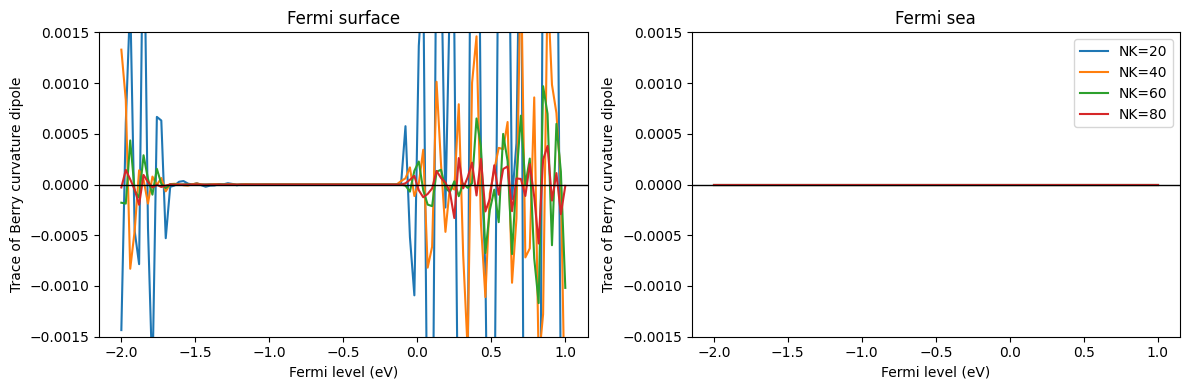

In [13]:
ic = 0
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for nk in sorted(list(data_fsurf_all.keys())):
    c = f"C{ic}"
    axes[0].plot(efermi, np.trace(data_fsurf_all[nk], axis1=1, axis2=2), c=c, label=f"NK={nk}")
    axes[1].plot(efermi, np.trace(data_fsea_all[nk], axis1=1, axis2=2), c=c, label=f"NK={nk}")
    ic += 1
    
axes[0].set_title("Fermi surface")
axes[1].set_title("Fermi sea")

for ax in axes:
    ax.axhline(0, c="k", lw=1)
    ax.set_ylim([-1.5e-3, 1.5e-3])
    ax.set_xlabel("Fermi level (eV)")
    ax.set_ylabel("Trace of Berry curvature dipole")

axes[1].legend()
plt.tight_layout()
plt.show()

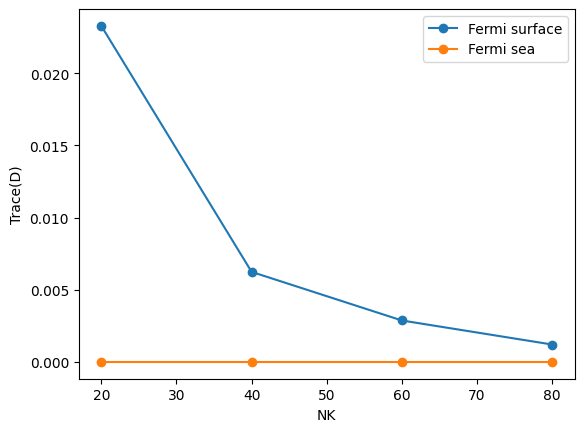

In [14]:
nklist = sorted(list(data_fsurf_all.keys()))
plt.plot(nklist, [np.linalg.norm(np.trace(data_fsurf_all[nk], axis1=1, axis2=2)) for nk in nklist], "o-", label="Fermi surface")
plt.plot(nklist, [np.linalg.norm(np.trace(data_fsea_all[nk], axis1=1, axis2=2)) for nk in nklist], "o-", label="Fermi sea")
plt.legend()
plt.xlabel("NK")
plt.ylabel("Trace(D)")
# plt.yscale("log")
plt.show()

## Model 2: Ferroelectric germanium telluride (α-GeTe)

The second model is an ab-initio tighit-binding model of ferroelectric GeTe. This material has a rhombohedrally distorted rocksalt structure where the Te atom is shifted from the center of the unit cell along the [111] direction.

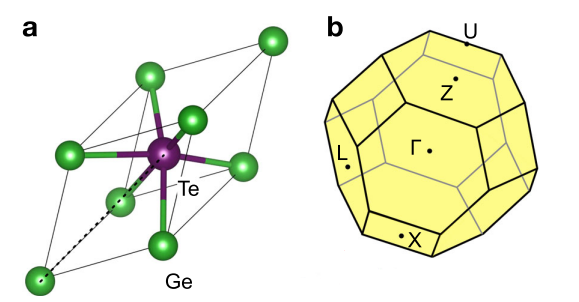

Figure taken from H. Wang et al, npj Computational Materials, 6, 7 (2020).

We load the system from a Wannier90 output. We set symmetry using the `set_symmetry_from_structure` method, which calls spglib to automatically determine the symmetry of the system.

We also symmetrize the system. See `data_GeTe/GeTe.win` file and check that the initial projections are correct. For details, refer to the symmetrization tutorial.

In [2]:
system_GeTe = wberri.System_w90("../data_GeTe/GeTe", berry=True)
system_GeTe.set_structure([[0., 0., 0.], [0.4688262167, 0.4688262167, 0.4688262167]], ["Ge", "Te"])
system_GeTe.set_symmetry_from_structure()

system_GeTe.symmetrize(
    proj=["Ge:s", "Ge:p", "Te:s", "Te:p"],
    atom_name=["Ge", "Te"],
    positions=[[0., 0., 0.], [0.4688262167, 0.4688262167, 0.4688262167]],
    soc=False,
)

kwargs for mmn are {'read_npz': True, 'write_npz': True}
calling w90 file with ../data_GeTe/GeTe, mmn, tags=['data', 'neighbours', 'G'], read_npz=True, write_npz=True, kwargs={'npar': 32}
kwargs for eig are {'read_npz': True, 'write_npz': True}
calling w90 file with ../data_GeTe/GeTe, eig, tags=['data'], read_npz=True, write_npz=True, kwargs={}
Reading restart information from file ../data_GeTe/GeTe.chk :
Time to read .chk : 0.001489877700805664
setting Rvec
expjphase1 (1, 8, 8)
Real-space lattice:
 [[ 2.11676981 -1.22211762  3.64031036]
 [ 0.          2.44423524  3.64031036]
 [-2.11676981 -1.22211762  3.64031036]]
Number of wannier functions: 8
Number of R points: 63
Recommended size of FFT grid [3 3 3]


 ---------- CRYSTAL STRUCTURE ---------- 


Cell vectors in angstroms:

      Vectors of DFT cell       
a0 =  2.1168  -1.2221   3.6403  
a1 =  0.0000   2.4442   3.6403  
a2 = -2.1168  -1.2221   3.6403  



 ---------- SPACE GROUP ----------- 


Space group: R3m1' (# 160.66)
Number o

In [3]:
path = wberri.Path(
    system_GeTe,
    k_nodes=[
        [0.00000, 0.00000, 0.00000], # GAMMA
        [0.50000, 0.00000, 0.00000], # L
        [0.62910, 0.62910, 0.24180], # U
        [0.50000, 0.50000, 0.00000], # X
        [0.00000, 0.00000, 0.00000], # GAMMA
        [0.50000, 0.50000, 0.50000], # Z
        [0.62910, 0.62910, 0.24180], # U
    ],
    labels=["$\Gamma$","L","U","X", "$\Gamma$", "Z", "U"],
    length=50
)

calculators = {
    "tabulate": calc.TabulatorAll(
        {"Energy": calc.tabulate.Energy()},
        ibands=np.arange(system_GeTe.num_wann),
        mode="path",
    )
}

path_result = wberri.run(
    system_GeTe,
    grid=path,
    calculators=calculators,
    parallel=parallel,
    print_Kpoints = False,
)

path_result = path_result.results["tabulate"]

Starting run()
Using the follwing calculators : 
############################################################

 'tabulate'  :  <wannierberri.calculators.tabulate.TabulatorAll object at 0x78f36331ba10>  : 
    TabulatorAll - a pack of all k-resolved calculators (Tabulators)
    
 Includes the following tabulators : 
--------------------------------------------------
 "Energy" : <wannierberri.calculators.tabulate.Energy object at 0x78f363c1d8e0> : calculator not described

--------------------------------------------------

############################################################
Calculation along a path - checking calculators for compatibility
tabulate <wannierberri.calculators.tabulate.TabulatorAll object at 0x78f36331ba10>
All calculators are compatible
Symmetrization switched off for Path
Grid is regular
The set of k points is a Path() with 39 points and labels {0: '$\\Gamma$', 7: 'L', 15: 'U', 18: 'X', 26: '$\\Gamma$', 33: 'Z', 38: 'U'}
generating K_list
Done 
Done, sum of weigh

<>:12: SyntaxWarning: invalid escape sequence '\G'
<>:12: SyntaxWarning: invalid escape sequence '\G'
<>:12: SyntaxWarning: invalid escape sequence '\G'
<>:12: SyntaxWarning: invalid escape sequence '\G'
/tmp/ipykernel_100008/1250455147.py:12: SyntaxWarning: invalid escape sequence '\G'
  labels=["$\Gamma$","L","U","X", "$\Gamma$", "Z", "U"],
/tmp/ipykernel_100008/1250455147.py:12: SyntaxWarning: invalid escape sequence '\G'
  labels=["$\Gamma$","L","U","X", "$\Gamma$", "Z", "U"],
/home/stepan/github/wannier-berri/wannierberri/grid/path.py:163: UserWarning: symmetry is not used for a tabulation along path
  warnings.warn("symmetry is not used for a tabulation along path")


time for processing     39 K-points on  16 processes:     0.9368 ; per K-point          0.0240 ; proc-sec per K-point          0.3843
time1 =  0.00039196014404296875
Totally processed 39 K-points 
run() finished


In [4]:
# Calculate the VBM and CBM energies using a 30*30*30 grid.
calculators = {
    "tabulate": calc.TabulatorAll(
        {"Energy": calc.tabulate.Energy()},
        ibands=np.arange(system_GeTe.num_wann),
        mode="grid",
    )
}

grid_energy_result = wberri.run(
    system_GeTe,
    grid=wberri.Grid(system_GeTe, NK=30),
    calculators=calculators,
    parallel=parallel,
    print_Kpoints = False,
)

grid_energy_result = grid_energy_result.results["tabulate"]

e_vbm_GeTe = np.amax(grid_energy_result.get_data("Energy", 4))
e_cbm_GeTe = np.amin(grid_energy_result.get_data("Energy", 5))
print(f"Valence band maximum   : {e_vbm_GeTe:6.3f}")
print(f"Conduction band minimum: {e_cbm_GeTe:6.3f}")

print("VBM k point: ", grid_energy_result.kpoints[np.argmax(grid_energy_result.get_data("Energy", 0))])
print("CBM k point: ", grid_energy_result.kpoints[np.argmin(grid_energy_result.get_data("Energy", 1))])

Minimal symmetric FFT grid :  [3 3 3]
Starting run()
Using the follwing calculators : 
############################################################

 'tabulate'  :  <wannierberri.calculators.tabulate.TabulatorAll object at 0x78f328046ba0>  : 
    TabulatorAll - a pack of all k-resolved calculators (Tabulators)
    
 Includes the following tabulators : 
--------------------------------------------------
 "Energy" : <wannierberri.calculators.tabulate.Energy object at 0x78f340119880> : calculator not described

--------------------------------------------------

############################################################
Calculation on  grid - checking calculators for compatibility
tabulate <wannierberri.calculators.tabulate.TabulatorAll object at 0x78f328046ba0>
All calculators are compatible
Grid is regular
The set of k points is a Grid() with NKdiv=[10 10 10], NKFFT=[3 3 3], NKtot=[30 30 30]
generating K_list
Done in 0.002313852310180664 s 
excluding symmetry-equivalent K-points from 

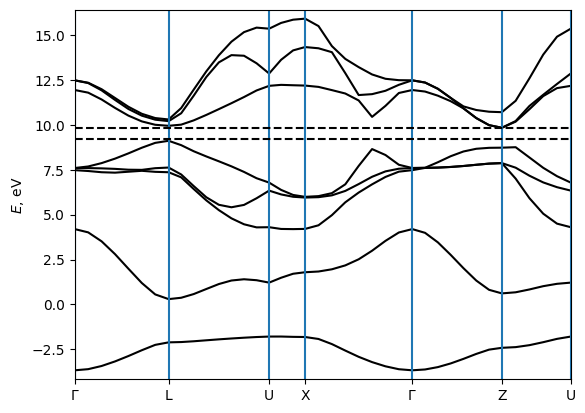

In [5]:
fig = path_result.plot_path_fat(path, close_fig=False, show_fig=False)

ax = fig.get_axes()[0]
ax.axhline(e_vbm_GeTe, c="k", ls="--")
ax.axhline(e_cbm_GeTe, c="k", ls="--")
plt.show(fig)

We compute the BCD tensor for the hole-doped case. (The electron-doped case is much harder to converge due to band crossings near the CBM.)

Try to calculate BCD for various grids and compare the convergence of the two methods. (NK=120 will be enough to see convergence.)

In [7]:
from wannierberri import calculators as calc
from wannierberri.smoother import FermiDiracSmoother

efermi = np.linspace(e_vbm_GeTe - 1.5, e_cbm_GeTe, 301, True)
smoother = FermiDiracSmoother(efermi, 300.0)

kwargs = dict(
    Efermi=efermi,
    smoother=smoother,
)

calculators = {
    'berry_dipole_fermi_sea': calc.static.BerryDipole_FermiSea(**kwargs),
    'berry_dipole_fermi_surface': calc.static.BerryDipole_FermiSurf(**kwargs),
}

In [8]:
data_GeTe_fsurf_all = {}
data_GeTe_fsea_all = {}

for nk in [20, 30, 40, 60, 80, 120]:
    grid = wberri.Grid(system_GeTe, NK=nk)
    result = wberri.run(
        system_GeTe,
        grid=grid,
        calculators=calculators,
        parallel=parallel,
        print_Kpoints = False,
    )
    data_GeTe_fsurf_all[nk] = result.results['berry_dipole_fermi_surface'].dataSmooth
    data_GeTe_fsea_all[nk] = result.results['berry_dipole_fermi_sea'].dataSmooth

Minimal symmetric FFT grid :  [3 3 3]
Starting run()
Using the follwing calculators : 
############################################################

 'berry_dipole_fermi_sea'  :  <wannierberri.calculators.static.BerryDipole_FermiSea object at 0x78f3280848c0>  : Berry curvature dipole (dimensionless)

        | With Fermi sea integral. Eq(29) in `Ref <https://www.nature.com/articles/s41524-021-00498-5>`__
        | Output: :math:`D_{\beta\delta} = \int [dk] \partial_\beta \Omega_\delta f`
 'berry_dipole_fermi_surface'  :  <wannierberri.calculators.static.BerryDipole_FermiSurf object at 0x78f3280cbfe0>  : Berry curvature dipole (dimensionless)

        | With Fermi surface integral. Eq(8) in `Ref <https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.115.216806>`__
        | Output: :math:`D_{\beta\delta} = -\int [dk] v_\beta \Omega_\delta f'`
############################################################
Calculation on  grid - checking calculators for compatibility
berry_dipole_fermi_

time for processing     19 K-points on  16 processes:     0.1912 ; per K-point          0.0101 ; proc-sec per K-point          0.1610
time1 =  0.002107858657836914
Totally processed 19 K-points 
run() finished
Minimal symmetric FFT grid :  [3 3 3]
Starting run()
Using the follwing calculators : 
############################################################

 'berry_dipole_fermi_sea'  :  <wannierberri.calculators.static.BerryDipole_FermiSea object at 0x78f3280848c0>  : Berry curvature dipole (dimensionless)

        | With Fermi sea integral. Eq(29) in `Ref <https://www.nature.com/articles/s41524-021-00498-5>`__
        | Output: :math:`D_{\beta\delta} = \int [dk] \partial_\beta \Omega_\delta f`
 'berry_dipole_fermi_surface'  :  <wannierberri.calculators.static.BerryDipole_FermiSurf object at 0x78f3280cbfe0>  : Berry curvature dipole (dimensionless)

        | With Fermi surface integral. Eq(8) in `Ref <https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.115.216806>`__
        | Ou

In [12]:
nk = 20
print("Shape of data: ", data_GeTe_fsurf_all[nk].shape)

print("Maximum value for each components (Fermi surface): ")
print(np.amax(abs(data_GeTe_fsurf_all[nk]), axis=0))

print("Maximum value for each components (Fermi sea): ")
print(np.amax(abs(data_GeTe_fsea_all[nk]), axis=0))

Shape of data:  (301, 3, 3)
Maximum value for each components (Fermi surface): 
[[5.83625890e-19 4.82033606e-02 8.44858920e-19]
 [4.82033606e-02 3.26505102e-19 2.04911009e-19]
 [1.35354371e-18 1.59827632e-19 5.74866053e-19]]
Maximum value for each components (Fermi sea): 
[[7.63931109e-19 4.51984438e-02 1.34671495e-18]
 [4.51984438e-02 3.71736785e-19 5.77229237e-19]
 [1.31145095e-18 1.40333414e-19 2.89294300e-19]]


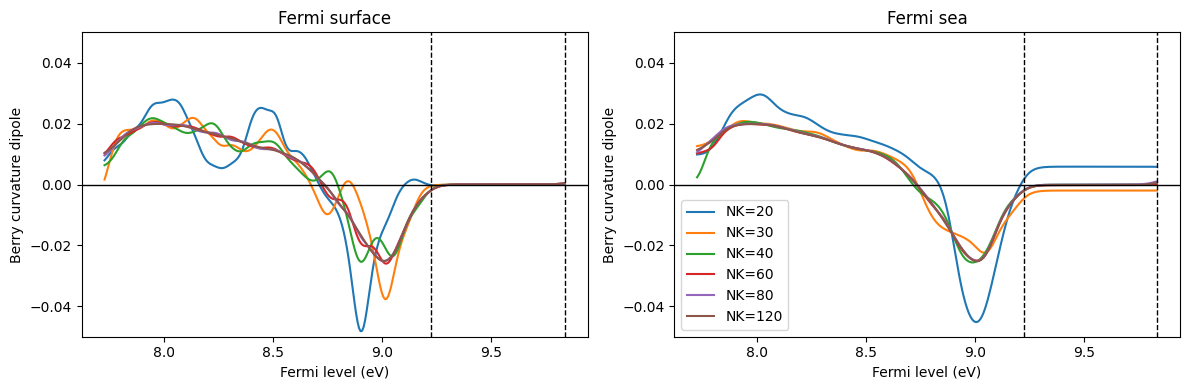

In [13]:
ic = 0
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for nk in sorted(list(data_GeTe_fsurf_all.keys())):
    c = f"C{ic}"
    axes[0].plot(efermi, data_GeTe_fsurf_all[nk][:, 0, 1], c=c, label=f"NK={nk}")
    axes[1].plot(efermi, data_GeTe_fsea_all[nk][:, 0, 1], c=c, label=f"NK={nk}")
    ic += 1

axes[0].set_title("Fermi surface")
axes[1].set_title("Fermi sea")

for ax in axes:
    ax.axhline(0, c="k", lw=1)
    ax.axvline(e_vbm_GeTe, c="k", lw=1, ls="--")
    ax.axvline(e_cbm_GeTe, c="k", lw=1, ls="--")
    ax.set_ylim([-0.05, 0.05])
    ax.set_xlabel("Fermi level (eV)")
    ax.set_ylabel("Berry curvature dipole")

axes[1].legend()
plt.tight_layout()
plt.show()

Let us focus on the undoped case: Fermi level between the VBM and the CBM. Then, $\frac{\partial}{\partial k^a} f_0 (\varepsilon_{n\mathbf{k}}) =0 $ holds so that the BCD is always 0.
For the Fermi surface method, the integrand is 0 at every k point, so the integral is also 0.
However, for the Fermi sea method, the integrand is not 0, and the integral becomes 0 only due to a calculation.

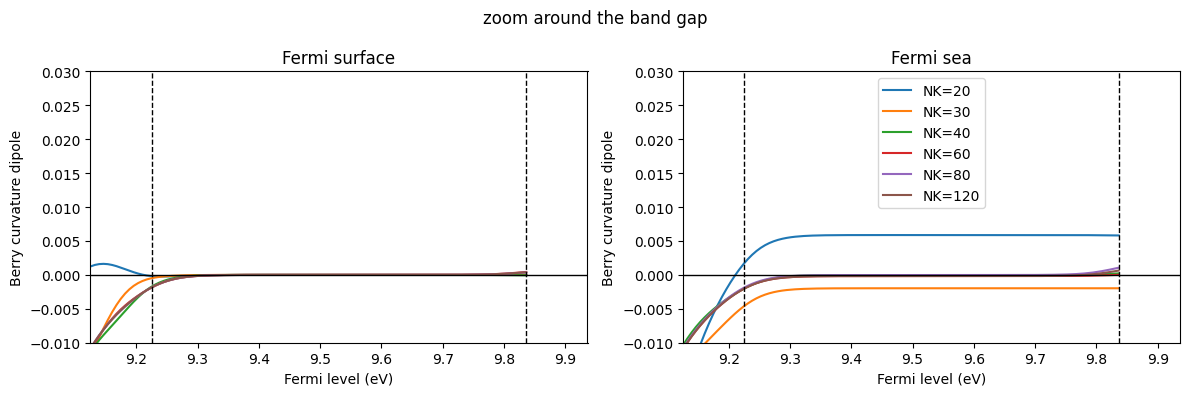

In [14]:
ic = 0
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for nk in sorted(list(data_GeTe_fsurf_all.keys())):
    c = f"C{ic}"
    axes[0].plot(efermi, data_GeTe_fsurf_all[nk][:, 0, 1], c=c, label=f"NK={nk}")
    axes[1].plot(efermi, data_GeTe_fsea_all[nk][:, 0, 1], c=c, label=f"NK={nk}")
    ic += 1

axes[0].set_title("Fermi surface")
axes[1].set_title("Fermi sea")

for ax in axes:
    ax.axhline(0, c="k", lw=1)
    ax.axvline(e_vbm_GeTe, c="k", lw=1, ls="--")
    ax.axvline(e_cbm_GeTe, c="k", lw=1, ls="--")
    ax.set_xlabel("Fermi level (eV)")
    ax.set_ylabel("Berry curvature dipole")
    ax.set_ylim(np.array([-0.01, 0.03]) * 1)
    ax.set_xlim([e_vbm_GeTe - 0.1, e_cbm_GeTe + 0.1])

axes[1].legend()
fig.suptitle("zoom around the band gap")
plt.tight_layout()
plt.show()

D_xy for the undoped case
NK :  [20, 30, 40, 60, 80, 120]
Fermi sea:  [np.float64(0.005868797821571347), np.float64(-0.001974244136048048), np.float64(-4.106357261372514e-05), np.float64(-0.00017425364359295427), np.float64(-2.5997303955030933e-05), np.float64(-0.00017942767877330914)]
Fermi surface:  [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)]


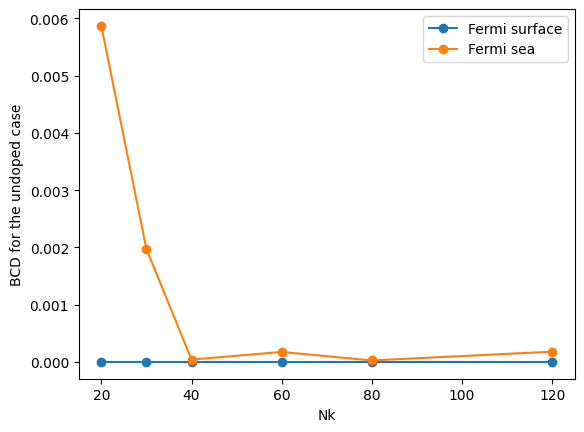

In [19]:
# Choose the Fermi level index at the middle of the band gap.
ifermi = np.argmin(np.abs(efermi - (e_vbm_GeTe + e_cbm_GeTe) / 2))

nklist = sorted(list(data_GeTe_fsurf_all.keys()))

print("D_xy for the undoped case")
print("NK : ", nklist)
print("Fermi sea: ", [data_GeTe_fsea_all[nk][ifermi, 0, 1] for nk in nklist])
print("Fermi surface: ", [data_GeTe_fsurf_all[nk][ifermi, 0, 1] for nk in nklist])

plt.plot(nklist, [abs(data_GeTe_fsurf_all[NK][ifermi, 0, 1]) for NK in nklist], "o-", label="Fermi surface")
plt.plot(nklist, [abs(data_GeTe_fsea_all[NK][ifermi, 0, 1]) for NK in nklist], "o-", label="Fermi sea")
plt.legend()
# plt.yscale("log") # Also try logscale
plt.xlabel("Nk")
plt.ylabel("BCD for the undoped case")
plt.show()

## Further questions

If you are interested, try to answer the following questions:
- What happens if one uses an un-symmetrized model? Does Fermi sea BCD with the Fermi energy inside the gap converge to 0?
- What happens if one uses the tetrahedron method?
- What happens for the zero-temperature case (you may use `.data` instead of `.dataSmooth`)?